# Predicting Tomorrow's Temperature in Tampa, Florida

Our objective is to predict tomorrow's temperature given x number of previous days temperatures. 

Our model, therefore, must accept x number of features -- each of which as the measures of temperatures, in sequence, over the past x days

To get our data, go to https://climatecenter.fsu.edu/climate-data-access-tools/downloadable-data and download weather data for the past 51 years. Select Tampa for the data set, and mean temperature as the value. Downlown this data (it will be in csv format) and store it in your working directory (the directory this notebook is in).


The following sequence of code will prepare our data for analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

np.random.seed(1)
tf.random.set_seed(1)
epoch_num = 10 # this needs to be set much higher if we are to get a good model -- but, higher number of epochs takes more training time

## Collect and prepare data for analysis

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/prof-tcsmith/data/master/TampaTemps.csv',  parse_dates=True)

In [3]:
df.columns

Index(['COOPID', ' YEAR', ' MONTH', ' DAY', ' meanTemp'], dtype='object')

In [4]:
df = df[[' meanTemp']]  # watch the spaces in the column name 

In [5]:
df

,meanTemp
0,70.0
1,71.5
2,72.0
3,71.5
4,73.5
...,...
18654,54.0
18655,61.5
18656,68.0
18657,71.0


In [6]:
df[' meanTemp'].isna().sum()

0

In [7]:
row_count = df.shape[0] # store the number of obersvations (daily temperature readings)
row_count

18659

In [8]:
temps = df.to_numpy() # to make things easier, we create a numpy array from our dataframe of temperatures
temps.shape

(18659, 1)

> NOTE: In the next few cells, we create a 'sliding window' of temperature data. This is a common technique in time series analysis. The idea is to use a window of 'n' days to predict the temperature on the 'n+1' day. In this case, we are using 60 days to predict the 61st day. This is a simple example, but the concept is used in many more complex time series models.
>
> NOTE2: Keras provides a function that can make creating these 'sliding windows' easier. See: [timeseries_dataset_from_array](https://keras.io/api/data_loading/timeseries/)

In [9]:
sequence_length = 60  # here, I create a variable to hold the number of days that will be in a sequence. This makes it easier to change later.

In [10]:
temps = temps[row_count % sequence_length: ] # Since our data may not be a multiple of sequence_length, we will ignore 
# the first number of days in order to make the total a number divisible by sequence length
temps.shape

(18600, 1)

In [11]:
temps = temps.reshape(row_count // sequence_length, sequence_length) # note that temps are a multiple of sequence length, we can split the data into rows of sequence length.
temps

array([[67.5, 70.5, 71. , ..., 69.5, 68. , 70. ],
       [71.5, 74. , 75. , ..., 81.5, 83.5, 83.5],
       [84. , 83.5, 84.5, ..., 78. , 81. , 81. ],
       ...,
       [87.5, 88. , 87. , ..., 86.5, 84.5, 82. ],
       [84.5, 86.5, 87. , ..., 79. , 78. , 80. ],
       [83. , 79.5, 76.5, ..., 68. , 71. , 68.5]])

In [13]:
# create our X and y. 
# X will be the 59 days prior...
X = temps[:, :-1] # all rows, all columns except the last one
# y will be the 60th day (what we are trying to predict)
y = temps[:, -1] # all rows, only the last column

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [15]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)
print(X_test.shape)

(217, 59, 1)
(93, 59, 1)


In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Conv1D

n_steps = sequence_length - 1
n_inputs = 1

model = Sequential(
    [
        SimpleRNN(64, input_shape=[n_steps, n_inputs]),
        Dense(1, activation=None)
    ]
)
model.summary()

2024-04-09 06:56:34.235653: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-09 06:56:34.235684: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-09 06:56:34.235692: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-09 06:56:34.235709: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-09 06:56:34.235722: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/timsmith/miniconda3/envs/dsp/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When usin

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289 (16.75 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# If multiclass, use "sparse_categorical_crossentropy" as the loss function
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=epoch_num,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/10


2024-04-09 06:56:34.895697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 971ms/step - loss: 5264.5615 - root_mean_squared_error: 72.5447 - val_loss: 4810.4629 - val_root_mean_squared_error: 69.4000
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 915ms/step - loss: 5180.6040 - root_mean_squared_error: 71.9644 - val_loss: 4708.3496 - val_root_mean_squared_error: 68.6598
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 925ms/step - loss: 5070.7686 - root_mean_squared_error: 71.1972 - val_loss: 4603.0918 - val_root_mean_squared_error: 67.8887
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 872ms/step - loss: 4961.3335 - root_mean_squared_error: 70.4250 - val_loss: 4483.4663 - val_root_mean_squared_error: 67.0013
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 817ms/step - loss: 4833.2354 - root_mean_squared_error: 69.5097 - val_loss: 4361.1753 - val_root_mean_squared_error: 66.0816
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 806ms/step - loss: 4707.6602 - root_mean_squared_error: 68.6005 - val_loss: 4248.3379 - val_root_mean_squared_error: 65.2216
Epoch 7/10
7/7 ━━━━━━━━━━━━

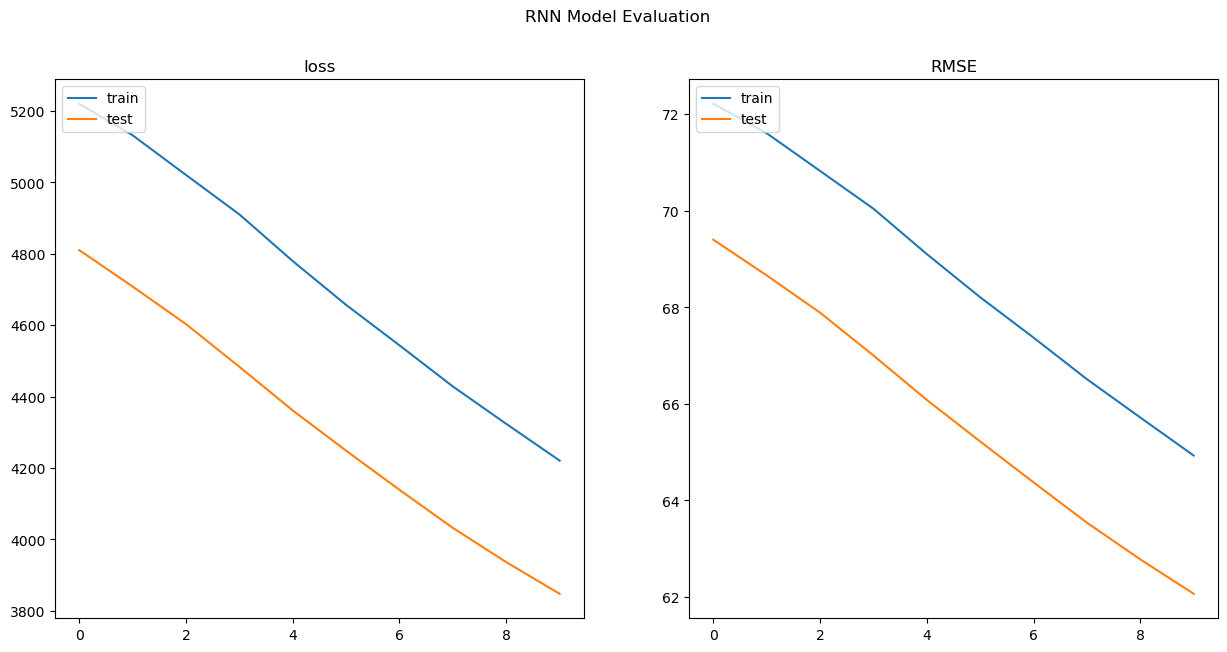

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('RNN Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

> NOTE: We can see by the above diagrams that more training would be beneficial. However, the training time is quite long. For this in-class example, I've kept the training time short. However, for a real-world application, we would want to train for a longer period of time.

In [20]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

mean_squared_error(y_test, y_pred)**0.5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


62.06806468677048

Now, let's say our past 59 days of temperatures were as follow....

In [21]:
prior_days = np.array(
    [
        77,75,79,85,78,75,81,83,87,80, 
        76,72,81,82,79,78,82,80,81,81, 
        74,76,82,83,75,77,83,81,83,80, 
        79,77,78,84,76,76,82,83,85,83, 
        76,74,79,85,77,72,83,82,83,84, 
        78,77,80,81,78,74,81,84,87, 
    ]
)

# reshape into the three dimensions for input into model
prior_days = prior_days.reshape(1, 59, 1) # 1 row, 59 time steps (features), and 1 output/prediction)

In [22]:
model.predict(prior_days) # note the structure of the prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[10.303072]], dtype=float32)

In [23]:
tomorrows_temp = model.predict(prior_days)[0][0] # we see the predicted temp is embedded inside two dimensions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


In [24]:
print(f"Tomorrow's predicted temperature is {tomorrows_temp:.2f} degrees Fahrenheit.")

Tomorrow's predicted temperature is 10.30 degrees Fahrenheit.
